# Ultrasound bone segmentation

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import sklearn" || pip install -q scikit-learn
!python -c "import cv2" || pip install -q opencv-python
%matplotlib inline

## Imports

In [2]:
from glob import glob
import os
import tempfile
import random
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
import cv2
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm, trange

import monai
from monai.data import (
    Dataset,
    CacheDataset,
    PersistentDataset,
    DataLoader,
)
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks import eval_mode
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AddChanneld,
    AsDiscrete,
    Compose,
    LoadImaged,
    ToTensord,
    Resized,
    RandFlipd,
    RandAffined,
    Randomizable,
    Lambda,
    Resize,
    ToTensor,
)
from monai.utils import set_determinism
from monai.data import decollate_batch

monai.config.print_config()

# Set deterministic training for reproducibility
set_determinism(seed=0)

MONAI version: 0.6.0+63.g1a4e9126
Numpy version: 1.21.1
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 1a4e9126efe8a66c1faa2555a5f342557d46af1e

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.3.1
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0+cu102
tqdm version: 4.61.2
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.0
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Transforms

In [3]:
out_im_size = 256
rotation_10deg = np.pi/18.0
translate_1_8th_of_image = out_im_size / 8
keys = ["image", "label"]
train_transforms = Compose([
    LoadImaged(keys),
    AddChanneld(keys),
    Resized(keys, (out_im_size, out_im_size), mode=["area", "nearest"]),
    RandFlipd(keys, prob=0.5, spatial_axis=1),
    RandAffined(
        keys,
        prob=0.8,
        rotate_range=rotation_10deg,
        translate_range=translate_1_8th_of_image, 
        mode=["bilinear", "nearest"],
        padding_mode="zeros",
    ),
    ToTensord(keys),
])
val_transforms = Compose([
    i for i in train_transforms.transforms if not isinstance(i, Randomizable)
])

## Datasets and dataloaders

In [4]:
def get_ds_and_dl(data, transforms, dataset="cachedataset"):
    if dataset.lower() == "cachedataset":
        ds = CacheDataset(data, transforms, num_workers=10)
    elif dataset.lower() == "persistentdataset":
        cache_dir = os.path.join(data_dir, "PersistentDataset_cache")
        ds = PersistentDataset(data, transforms, cache_dir)
    else:
        ds = Dataset(data, transforms)
    dl = DataLoader(ds, batch_size=10, num_workers=10, drop_last=True, shuffle=True)
    return ds, dl

## Data

Get data and set path accordingly below

In [5]:
root_dir = os.environ["MONAI_DATA_DIRECTORY"]
assert root_dir is not None
data_dir = os.path.join(root_dir, "UltraSound")
assert os.path.isdir(data_dir)

In [6]:
unprocessed_dir = os.path.join(data_dir, "unprocessed")
npy_files = glob(os.path.join(unprocessed_dir, "*.npy"))
image_vids = sorted([i for i in npy_files if "ultrasound" in os.path.basename(i)])[::-1]
label_vids = sorted([i for i in npy_files if "segmentation" in os.path.basename(i)])[::-1]
test_image_vid = image_vids.pop()
test_label_vid = label_vids.pop()

def extract_vid_frames(vid_files):
    frame_files = []
    for frame_count, file in enumerate(tqdm(vid_files, desc="extracting frames from vids")):
        im = np.load(file).squeeze(-1)
        for frame_count, frame in enumerate(im):
            out_dir = os.path.join(Path(file).parent.parent, "single_frames")
            os.makedirs(out_dir, exist_ok=True)
            out_fname = Path(file).name[:-4] + f"_frame{frame_count}.npy"
            frame_files.append(os.path.join(out_dir, out_fname))
            if not os.path.isfile(frame_files[-1]):
                np.save(frame_files[-1], frame)
    return frame_files

image_frames = extract_vid_frames(image_vids)
label_frames = extract_vid_frames(label_vids)
test_image_frames = extract_vid_frames([test_image_vid])
test_label_frames = extract_vid_frames([test_label_vid])

extracting frames from vids: 100%|██████████| 1/1 [00:00<00:00, 22.36it/s]


In [7]:
data_dict = [{"image": i, "label": l} for i, l in zip(image_frames, label_frames)]
print("Total num frames", len(data_dict))

train_file_dict, val_file_dict = train_test_split(
    data_dict, test_size=int(0.2 * len(data_dict))
)

test_file_dict = [{"image": i, "label": l} for i, l in zip(test_image_frames, test_label_frames)]

print("Num training image/label pairs:", len(train_file_dict))
print("Num validation image/label pairs:", len(val_file_dict))
print("Num testing image/label pairs:", len(test_file_dict))

train_ds, train_dl = get_ds_and_dl(train_file_dict, train_transforms)
val_ds, val_dl = get_ds_and_dl(val_file_dict, val_transforms)
test_ds, test_dl = get_ds_and_dl(test_file_dict, val_transforms)

Total num frames 7949
Num training image/label pairs: 6360
Num validation image/label pairs: 1589
Num testing image/label pairs: 523


Loading dataset: 100%|██████████| 523/523 [00:00<00:00, 1195.71it/s]


## Show selection

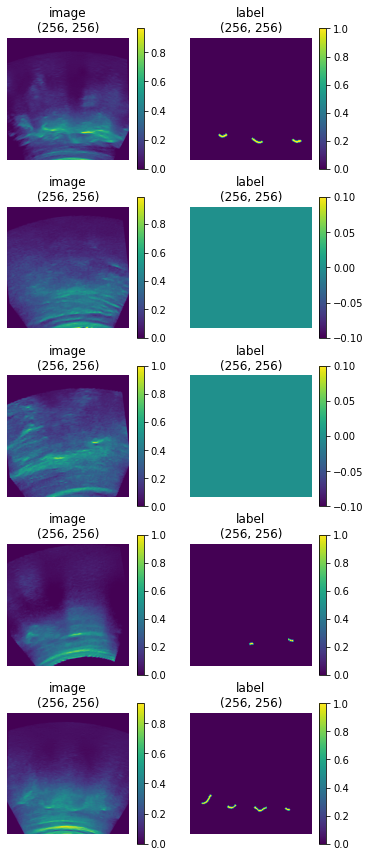

In [8]:
%matplotlib inline
def imshows(ims, colorbar=True):
    nrow = len(ims)
    ncol = len(ims[0])
    fig, axes = plt.subplots(nrow, ncol, figsize=(
        ncol * 3, nrow * 3), facecolor='white')
    for i, im_dict in enumerate(ims):
        for j, (title, im) in enumerate(im_dict.items()):
            if isinstance(im, torch.Tensor):
                im = im.detach().cpu().numpy()
            # If RGB, put to end. Else, average across channel dim
            if im.ndim > 2:
                im = np.moveaxis(im, 0, -1) if im.shape[0] == 3 else np.mean(im, axis=0)

            ax = axes[j] if len(ims) == 1 else axes[i, j]
            ax.set_title(f"{title}\n{im.shape}")
            im_show = ax.imshow(im)
            ax.axis("off")
            if colorbar:
                fig.colorbar(im_show, ax=ax)

to_imshow = []
for i in np.random.choice(train_ds, size=5, replace=False):
    to_imshow.append({k: i[k] for k in keys})
imshows(to_imshow)

In [9]:
# Create network, loss fn., etc.
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(threshold_values=True),
    Lambda(lambda x: torch.unsqueeze(x[:, 1, ...], 1)),
])
in_channels = train_ds[0]["image"].shape[0]
print("in channels:", in_channels)
# create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    dimensions=2,
    in_channels=in_channels,
    out_channels=2,
    channels=(2, 12, 22, 32, 42, 52, 62, 72),
    strides=(2, 2, 2, 2, 2, 2, 2),
    num_res_units=2,
    dropout=0.1,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
dice_metric = DiceMetric(reduction="mean")

use_dicece = True
if use_dicece:
    loss_function = DiceCELoss(
        sigmoid=True,
        to_onehot_y=True,
        lambda_dice=0.5,
        lambda_ce=0.5,
        ce_weight=torch.tensor((0.1, 0.9)).to(device),
    )
else:
    loss_function = DiceLoss(
        sigmoid=True,
        to_onehot_y=True,
    )

in channels: 1


In [10]:
def infer_seg(images, model):
    return post_trans(model(images))

In [11]:
best_model_path = "best_model_ultrasound_dicece.pth"
always_train = False
do_training = always_train or not os.path.isfile(best_model_path)
if do_training:

    # start a typical PyTorch training
    max_epochs = 1000
    val_interval = 1
    test_interval = 1
    best_metric = -1
    best_metric_epoch = -1
    writer = SummaryWriter()

    for epoch in trange(max_epochs):
        model.train()
        epoch_losses = []

        for batch_data in train_dl:
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        epoch_loss = np.mean(epoch_losses)
        writer.add_scalar("Loss/training", epoch_loss, epoch)
        writer.add_images("Train/image", inputs, epoch)
        writer.add_images("Train/label", labels, epoch)
        writer.add_images("Train/infer", post_trans(outputs), epoch)

        if (epoch + 1) % val_interval == 0:
            with eval_mode(model):
                metric_list = []
                for val_data in val_dl:
                    val_images, val_labels = val_data["image"].to(
                        device), val_data["label"].to(device)
                    val_outputs = infer_seg(val_images, model)
                    value = dice_metric(y_pred=val_outputs, y=val_labels)
                    metric_list += value[~value.isnan()].tolist()
            metric = np.mean(metric_list)
            writer.add_scalar("Loss/validation", metric, epoch)
            writer.add_images("Val/image", val_images, epoch)
            writer.add_images("Val/label", val_labels, epoch)
            writer.add_images("Val/infer", val_outputs, epoch)

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), best_model_path)
                
        if (epoch + 1) % test_interval == 0:
            with eval_mode(model):
                metric_list = []
                for test_data in test_dl:
                    test_images, test_labels = test_data["image"].to(
                        device), test_data["label"].to(device)
                    test_outputs = infer_seg(test_images, model)
                    value = dice_metric(y_pred=test_outputs, y=test_labels)
                    metric_list += value[~value.isnan()].tolist()
            metric = np.mean(metric_list)
            writer.add_scalar("Loss/test", metric, epoch)
            writer.add_images("Test/image", test_images, epoch)
            writer.add_images("Test/label", test_labels, epoch)
            writer.add_images("Test/infer", test_outputs, epoch)
            
    print(
        f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

In [12]:
model.load_state_dict(torch.load(best_model_path, map_location=device))
_ = model.eval()
# save as jit model
jit_fname = best_model_path[:-4] + "_jit.pt"
torch.jit.save(torch.jit.script(model.cpu()), jit_fname)
_ = model.to(device)

# Check segmentations

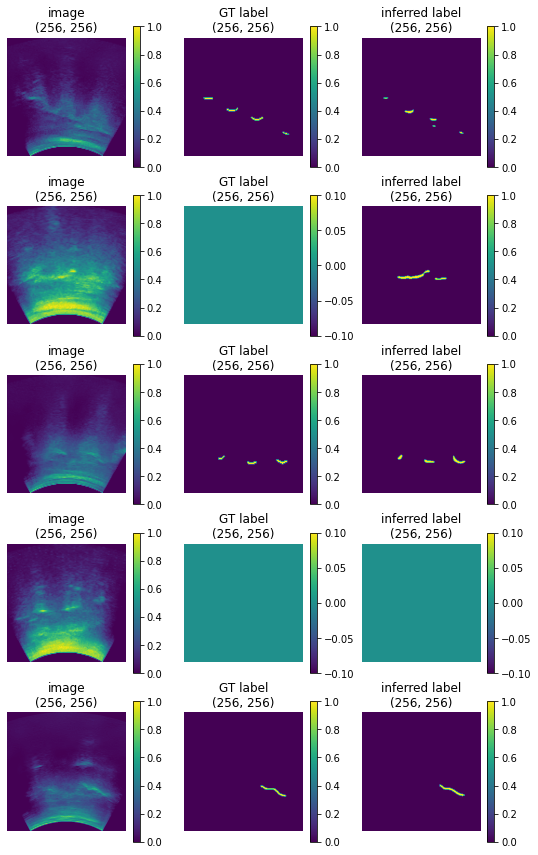

In [13]:
%matplotlib inline
to_imshow = []
for data in np.random.choice(val_ds, size=5, replace=False):
    im, label = data["image"], data["label"]
    im_gpu = im[None].to(device)
    inferred = infer_seg(im_gpu, model)[0]
    to_imshow.append({
        "image": im,
        "GT label": label,
        "inferred label": inferred,
    })
imshows(to_imshow)

## Time the inference

In [14]:
d = val_transforms(val_file_dict[0])
im_gpu = d["image"][None].to(device)

%timeit infer_seg(im_gpu, model)

8.41 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Generating video

In [19]:
def create_video(frames, output_file, fps, skip_if_present=False, codec="MJPG"):
    frames = frames.astype(np.uint8)
    if skip_if_present and os.path.isfile(output_file):
        print(f"video alread present, skipping: {output_file}.")
        return
    print(f"{len(frames)} frames @ {fps} fps: {output_file}...")
    
    fourcc = cv2.VideoWriter_fourcc(*codec)
    width_height = frames[0].shape[::-1]
    video = cv2.VideoWriter(output_file, fourcc, fps, width_height)

    for idx, frame in enumerate(frames):
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
        video.write(frame)
    video.release()
    if not os.path.isfile(output_file):
        raise RuntimeError("video not created:", output_file)

# videos are stored as npy files, convert to mp4 or similar
fps = 2  # ultrasound is 2Hz
out_vid_dir = os.path.join(data_dir, "videos")
os.makedirs(out_vid_dir, exist_ok=True)
for file in npy_files:
    out_fname = os.path.join(out_vid_dir, os.path.basename(file)[:-3] + "avi")
    frames = (np.load(file).squeeze(-1) * 255).astype(np.uint8)
    create_video(frames, out_fname, fps)

477 frames @ 2 fps: /home/rich/Documents/Data/MONAI/UltraSound/videos/q002_segmentation.avi...
523 frames @ 2 fps: /home/rich/Documents/Data/MONAI/UltraSound/videos/Q000_04_tu_segmented_ultrasound_256.avi...
453 frames @ 2 fps: /home/rich/Documents/Data/MONAI/UltraSound/videos/q003_ultrasound.avi...
387 frames @ 2 fps: /home/rich/Documents/Data/MONAI/UltraSound/videos/Q005_04_tu_segemented_ultrasound_256.avi...
453 frames @ 2 fps: /home/rich/Documents/Data/MONAI/UltraSound/videos/q003_segmentation.avi...
523 frames @ 2 fps: /home/rich/Documents/Data/MONAI/UltraSound/videos/q000_ultrasound.avi...
360 frames @ 2 fps: /home/rich/Documents/Data/MONAI/UltraSound/videos/Q006_04_tu_segemented_segmentation_256.avi...
523 frames @ 2 fps: /home/rich/Documents/Data/MONAI/UltraSound/videos/q000_segmentation.avi...
523 frames @ 2 fps: /home/rich/Documents/Data/MONAI/UltraSound/videos/Q000_04_tu_segmented_segmentation_256.avi...
360 frames @ 2 fps: /home/rich/Documents/Data/MONAI/UltraSound/videos/Q

In [22]:
# Create video of inference
test_transforms = Compose([
    Resize((out_im_size, out_im_size), mode="area"),
    ToTensor(),
])
def get_inferred_vid(file):
    frames = np.load(file).squeeze(-1)
    frames = test_transforms(frames)
    inferred_vid = []
    for frame in tqdm(frames):
        frame = frame[None][None].to(device)
        inferred_frame = infer_seg(frame, model)
        inferred_frame = inferred_frame.detach().cpu().numpy()[0][0]
        inferred_vid.append(inferred_frame)
    inferred_vid = np.asarray(inferred_vid)
    return inferred_vid

# for file in tqdm(get_vid_files("ultrasound")):
#     out_fname = os.path.join(out_vid_dir, os.path.basename(file)[:-4] + "_inferred.avi")
#     if os.path.isfile(out_fname):
#         continue
#     inferred_vid = get_inferred_vid(file)
#     inferred_vid = (inferred_frame * 255).astype(np.uint8)
#     create_video(inferred_vid, out_fname, fps)

In [34]:
# join test videos together
image = test_transforms(np.load(test_image_vid).squeeze(-1)).numpy()
label = test_transforms(np.load(test_label_vid).squeeze(-1)).numpy()
infer = get_inferred_vid(test_image_vid)
out_fname = os.path.join(out_vid_dir, os.path.basename(test_image_vid)[:-4] + "_inferred.avi")
create_video(infer, out_fname, fps)

100%|██████████| 523/523 [00:04<00:00, 117.33it/s]


523 frames @ 2 fps: /home/rich/Documents/Data/MONAI/UltraSound/videos/Q000_04_tu_segmented_ultrasound_256_inferred.avi...


In [37]:
combined_vid = np.hstack((image, label, infer))
combined_vid = (combined_vid * 255).astype(np.uint8)
out_fname = os.path.join(out_vid_dir, os.path.basename(test_image_vid)[:-4] + "_combined.avi")
create_video(combined_vid, out_fname, fps)

523 frames @ 2 fps: /home/rich/Documents/Data/MONAI/UltraSound/videos/Q000_04_tu_segmented_ultrasound_256_combined.avi...
